## Monte-Carlo Simulation for Derivatives Pricing

Monte Carlo simulations is a way of solving probabilistic problems by numerically simulating many possible scenarios so that you may calculate statistical properties of the outcomes, such as expectations, variances of probabilities of certain outcomes.

In the case of Financial Derivatives, this gives us a handy tool for which to price complex derivatives for which and analytical formulae is not possible.

First used by Boyle in 1977, Monte Carlo simulation provides an easy way to deal with multiple random factors and the incorporation of more realistic asset price processes such as jumps in asset prices.

Monte Carlo as a tool
We can solve two types of financial problems:

Portfolio statistics (Brownian Motion is representative of Real probabilities under P-measure)

Expected returns
Risk metrics (VaR, CVaR, ...)
Downside risks (Drawdown metrics,...)
other probabilities of interest
Pricing derivatives with risk-neutral pricing (Brownian Motion is representative of risk-neutral probabilities under Q-measure)



In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import datetime
import yfinance as yf

#### Génération du chemin d'évolution du sous-jacent

In [3]:
def generate_paths(S0, r, sigma, T, n_steps, n_paths):
    dt = T / n_steps
    Z = np.random.standard_normal((n_paths, n_steps))
    
    # Simulation exacte pour Black-Scholes
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    
    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = S0
    
    for t in range(1, n_steps + 1):
        paths[:, t] = paths[:, t-1] * np.exp(drift + diffusion * Z[:, t-1])
    
    return paths

    

#### Pricing 

In [4]:
def price_option(S0, K, r, sigma, T, n_paths, option_type='call'):
    paths = generate_paths(S0, r, sigma, T, n_steps=252, n_paths=n_paths)
    ST = paths[:, -1]  # Prix final
    
    # Calcul des payoffs
    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0)
    else:  # put
        payoffs = np.maximum(K - ST, 0)
    
    # Actualisation et moyenne
    price = np.exp(-r * T) * np.mean(payoffs)
    std_error = np.exp(-r * T) * np.std(payoffs) / np.sqrt(n_paths)
    
    return price, std_error


#### Réduire la variance avec les variables antithétiques

In [5]:
def generate_paths_antithetic(S0, r, sigma, T, n_steps, n_paths):
    dt = T / n_steps
    n_half = n_paths // 2
    Z = np.random.standard_normal((n_half, n_steps))
    
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    
    # Trajectoires avec Z
    paths_pos = np.zeros((n_half, n_steps + 1))
    paths_pos[:, 0] = S0
    
    # Trajectoires avec -Z
    paths_neg = np.zeros((n_half, n_steps + 1))
    paths_neg[:, 0] = S0
    
    for t in range(1, n_steps + 1):
        paths_pos[:, t] = paths_pos[:, t-1] * np.exp(drift + diffusion * Z[:, t-1])
        paths_neg[:, t] = paths_neg[:, t-1] * np.exp(drift - diffusion * Z[:, t-1])
    
    return np.vstack([paths_pos, paths_neg])


In [6]:
def price_with_control_variate(S0, K, r, sigma, T, n_paths, exotic_payoff_func):
    paths = generate_paths(S0, r, sigma, T, 252, n_paths)
    ST = paths[:, -1]
    
    # Payoff exotique (ce qu'on veut pricer)
    exotic_payoffs = exotic_payoff_func(paths)
    
    # Variable de contrôle: call européen
    control_payoffs = np.maximum(ST - K, 0)
    control_price_analytical = black_scholes_call(S0, K, r, sigma, T)
    
    # Régression pour trouver le coefficient optimal
    cov = np.cov(exotic_payoffs, control_payoffs)[0, 1]
    var_control = np.var(control_payoffs)
    beta = cov / var_control
    
    # Estimateur corrigé
    control_mean = np.mean(control_payoffs)
    adjusted_payoffs = exotic_payoffs - beta * (control_payoffs - control_mean)
    
    price = np.exp(-r * T) * (np.mean(adjusted_payoffs) + beta * control_price_analytical)
    return price


#### Classe Monte-Carlo

In [7]:
class MonteCarloEngine:
    def __init__(self, variance_reduction='antithetic'):
        self.variance_reduction = variance_reduction
    
    def price(self, derivative, n_paths=100000):
        if self.variance_reduction == 'antithetic':
            paths = self._generate_antithetic_paths(derivative, n_paths)
        elif self.variance_reduction == 'control_variate':
            return self._price_with_control(derivative, n_paths)
        else:
            paths = self._generate_standard_paths(derivative, n_paths)
        
        payoffs = derivative.payoff(paths)
        price = np.exp(-derivative.r * derivative.T) * np.mean(payoffs)
        return price

In [8]:
from abc import ABC, abstractmethod

class Derivative(ABC):
    def __init__(self, S0, K, r, sigma, T):
        self.S0 = S0      # Prix initial
        self.K = K        # Strike
        self.r = r        # Taux sans risque
        self.sigma = sigma # Volatilité
        self.T = T        # Maturité
    
    @abstractmethod
    def payoff(self, paths):
        """Calcule le payoff pour chaque trajectoire"""
        pass


#### Call Européen

Call Européen Classique.

Payoff = Max(ST - K ; 0)

In [9]:
class EuropeanCall(Derivative):
    def payoff(self, paths):
        ST = paths[:, -1]  # Prix final seulement
        return np.maximum(ST - self.K, 0)

class EuropeanPut(Derivative):
    def payoff(self, paths):
        ST = paths[:, -1]
        return np.maximum(self.K - ST, 0)


#### Call Asiatique

Average price (fixed strike) : 
le strike K est fixé dès le départ (comme une option “vanille”), et le payoff dépend de la moyenne A du sous-jacent sur la période d’observation : Payoff = max(A−K,0)

Average strike (floating strike) : ici, la moyenne du sous-jacent sur la période devient le strike (il “flotte”) et le payoff d’un call est typiquement : Payoff = max(ST − A,0)

Ici on travaille sur une option Average Price

In [10]:
class AsianCall(Derivative):
    def __init__(self, S0, K, r, sigma, T, averaging_type='arithmetic'):
        super().__init__(S0, K, r, sigma, T)
        self.averaging_type = averaging_type
    
    def payoff(self, paths):
        if self.averaging_type == 'arithmetic':
            avg_price = np.mean(paths, axis=1)  # Moyenne sur chaque trajectoire
        else:  # geometric
            avg_price = np.exp(np.mean(np.log(paths), axis=1))
        
        return np.maximum(avg_price - self.K, 0)


#### Options à barrières

Up and Out Call : Le call disparaît si on dépasse la barrière fixée

Down and In Put : Le put s'active si on passe en dessous de la barrière fixée

Le payoff est Max(Spot-K ; 0) 

In [11]:
class UpAndOutCall(Derivative):
    """Call qui devient sans valeur si le prix dépasse la barrière"""
    def __init__(self, S0, K, r, sigma, T, barrier):
        super().__init__(S0, K, r, sigma, T)
        self.barrier = barrier
    
    def payoff(self, paths):
        ST = paths[:, -1]
        max_price = np.max(paths, axis=1)  # Prix max sur chaque trajectoire
        
        # Payoff = 0 si la barrière a été touchée
        payoff = np.maximum(ST - self.K, 0)
        payoff[max_price >= self.barrier] = 0
        return payoff

class DownAndInPut(Derivative):
    """Put qui s'active seulement si le prix descend sous la barrière"""
    def __init__(self, S0, K, r, sigma, T, barrier):
        super().__init__(S0, K, r, sigma, T)
        self.barrier = barrier
    
    def payoff(self, paths):
        ST = paths[:, -1]
        min_price = np.min(paths, axis=1)
        
        # Payoff actif seulement si barrière touchée
        payoff = np.maximum(self.K - ST, 0)
        payoff[min_price >= self.barrier] = 0
        return payoff


#### Call Lookback

Le strike est égal au prix le plus bas observé sur la période

In [12]:
class LookbackCall(Derivative):
    """Payoff basé sur le minimum du prix pendant la période"""
    def payoff(self, paths):
        ST = paths[:, -1]
        min_price = np.min(paths, axis=1)
        return ST - min_price  # Achat au plus bas, vente au final


#### Simulation Monte-Carlo

In [13]:
class MonteCarloSimulator:
    def __init__(self, n_paths=100000, n_steps=252, seed=42):
        self.n_paths = n_paths
        self.n_steps = n_steps
        np.random.seed(seed)
    
    def generate_paths(self, derivative, antithetic=True):
        """Génère les trajectoires avec ou sans variables antithétiques"""
        dt = derivative.T / self.n_steps
        
        if antithetic:
            n_half = self.n_paths // 2
            Z = np.random.standard_normal((n_half, self.n_steps))
            Z = np.vstack([Z, -Z])  # Variables antithétiques
        else:
            Z = np.random.standard_normal((self.n_paths, self.n_steps))
        
        # Simulation exacte de Black-Scholes
        drift = (derivative.r - 0.5 * derivative.sigma**2) * dt
        diffusion = derivative.sigma * np.sqrt(dt)
        
        paths = np.zeros((self.n_paths, self.n_steps + 1))
        paths[:, 0] = derivative.S0
        
        for t in range(1, self.n_steps + 1):
            paths[:, t] = paths[:, t-1] * np.exp(drift + diffusion * Z[:, t-1])
        
        return paths
    
    def price(self, derivative, confidence_level=0.95):
        """Price le dérivé et retourne prix + intervalle de confiance"""
        paths = self.generate_paths(derivative)
        payoffs = derivative.payoff(paths)
        
        # Actualisation
        discount_factor = np.exp(-derivative.r * derivative.T)
        discounted_payoffs = discount_factor * payoffs
        
        # Calcul du prix et erreur standard
        price = np.mean(discounted_payoffs)
        std_error = np.std(discounted_payoffs) / np.sqrt(self.n_paths)
        
        # Intervalle de confiance
        from scipy import stats
        z_score = stats.norm.ppf((1 + confidence_level) / 2)
        ci_lower = price - z_score * std_error
        ci_upper = price + z_score * std_error
        
        return {
            'price': price,
            'std_error': std_error,
            'ci_95': (ci_lower, ci_upper)
        }


#### Pricing des différentes options

On calcule le payoff des options et on actualise la valeur pour avoir le pricing des options

De manière générale, on a : 
Prix(t=0)= exp(−rT) × E(Payoff(T))

In [22]:
# Paramètres de marché
S0 = 100       # Prix initial
K = 105        # Strike
r = 0.05       # Taux 5%
sigma = 0.20   # Vol 20%
T = 1.0        # 1 an

# Création du simulateur
simulator = MonteCarloSimulator(n_paths=100000, n_steps=252)
print("Valeur des payoffs et des options associées \n")

# 1. Option européenne (référence)
euro_call = EuropeanCall(S0, K, r, sigma, T)
result = simulator.price(euro_call)
print(f"European Call: {result['price']:.4f} ± {result['std_error']:.4f}")
print(f"prix de l'option (par actualisation) : {result['price']*np.exp(-1*r*T):.4f} \n")
print(f"IC 95%: [{result['ci_95'][0]:.4f}, {result['ci_95'][1]:.4f}] \n")

# 2. Option asiatique
asian_call = AsianCall(S0, K, r, sigma, T)
result = simulator.price(asian_call)
print(f"Asian Call: {result['price']:.4f}")
print(f"prix de l'option (par actualisation) : {result['price']*np.exp(-1*r*T):.4f} \n")

# 3. Option à barrière Up-and-Out
barrier_call = UpAndOutCall(S0, K, r, sigma, T, barrier=120)
result = simulator.price(barrier_call)
print(f"Up-and-Out Call: {result['price']:.4f}")
print(f"prix de l'option (par actualisation) : {result['price']*np.exp(-1*r*T):.4f} \n")

# 4. Lookback
lookback = LookbackCall(S0, K, r, sigma, T)
result = simulator.price(lookback)
print(f"Lookback Call: {result['price']:.4f}")
print(f"prix de l'option (par actualisation) : {result['price']*np.exp(-1*r*T):.4f} \n")


Valeur des payoffs et des options associées 

European Call: 7.9567 ± 0.0416
prix de l'option (par actualisation) : 7.5687 

IC 95%: [7.8752, 8.0383] 

Asian Call: 3.5072
prix de l'option (par actualisation) : 3.3362 

Up-and-Out Call: 0.5997
prix de l'option (par actualisation) : 0.5704 

Lookback Call: 16.6172
prix de l'option (par actualisation) : 15.8068 



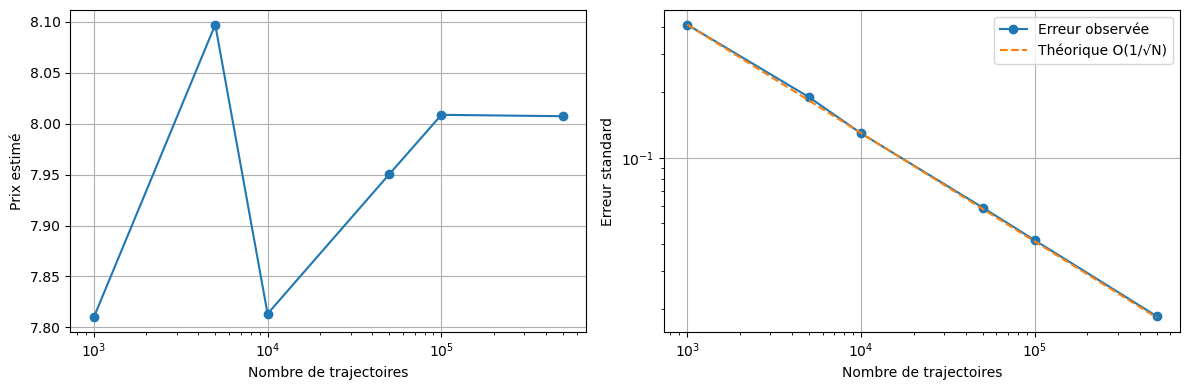

In [15]:
def convergence_analysis(derivative, path_counts):
    """Analyse la convergence en fonction du nombre de trajectoires"""
    simulator = MonteCarloSimulator(n_paths=max(path_counts))
    prices = []
    errors = []
    
    for n in path_counts:
        simulator.n_paths = n
        result = simulator.price(derivative)
        prices.append(result['price'])
        errors.append(result['std_error'])
    
    # Visualisation
    import matplotlib.pyplot as plt
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(path_counts, prices, 'o-')
    ax1.set_xlabel('Nombre de trajectoires')
    ax1.set_ylabel('Prix estimé')
    ax1.set_xscale('log')
    ax1.grid(True)
    
    ax2.loglog(path_counts, errors, 'o-', label='Erreur observée')
    ax2.loglog(path_counts, errors[0] * np.sqrt(path_counts[0] / np.array(path_counts)), 
               '--', label='Théorique O(1/√N)')
    ax2.set_xlabel('Nombre de trajectoires')
    ax2.set_ylabel('Erreur standard')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Test de convergence
path_counts = [1000, 5000, 10000, 50000, 100000, 500000]
convergence_analysis(euro_call, path_counts)


#### Plot des évolution des prix 

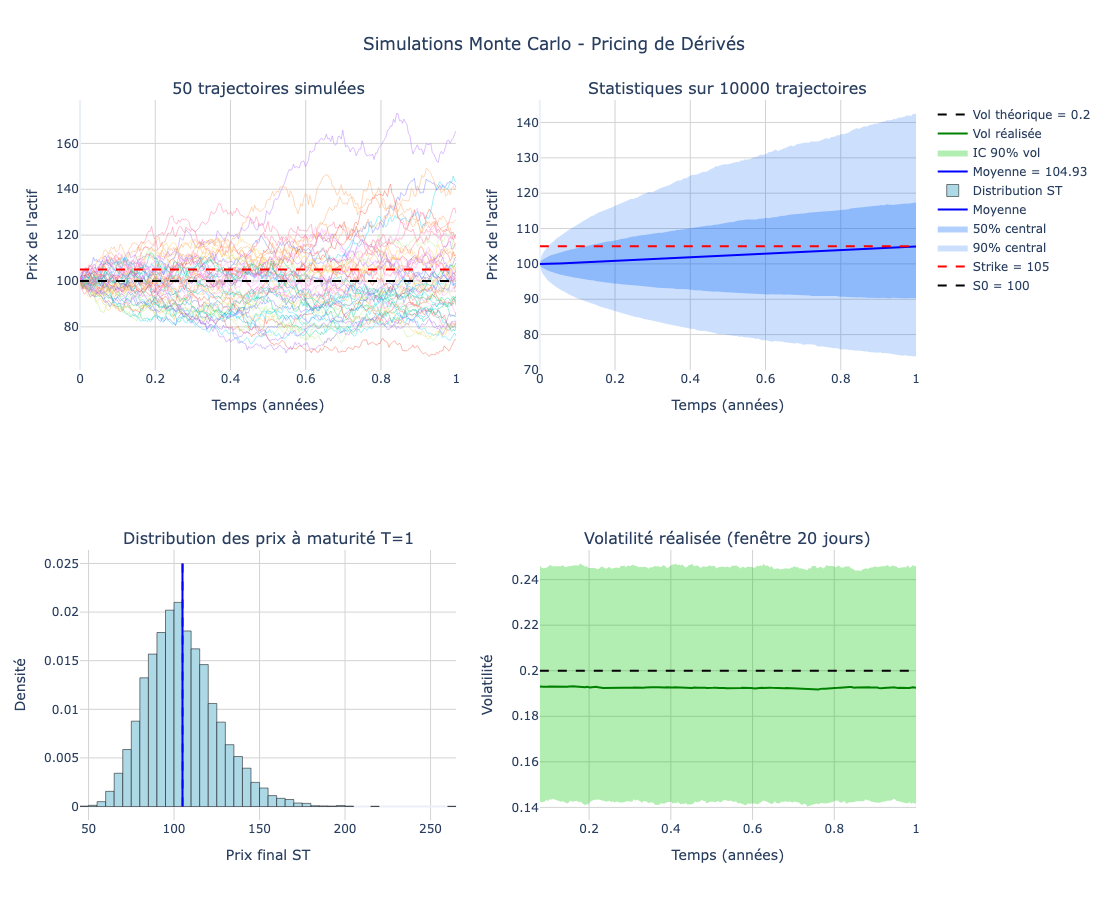

Prix initial: 100
Prix final moyen: 104.9325
Prix final médian: 102.8495
Volatilité: 20.9671 %
Probabilité ITM (ST > K): 45.85%


In [16]:
# Paramètres de marché
S0 = 100
K = 105
r = 0.05
sigma = 0.20
T = 1
n_steps = int(252*T)

# ============== GÉNÉRATION DES TRAJECTOIRES ==============
def generate_paths(S0, r, sigma, T, n_steps, n_paths, seed=42):
    """Génère les trajectoires Monte Carlo"""
    np.random.seed(seed)
    dt = T / n_steps
    Z = np.random.standard_normal((n_paths, n_steps))
    
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    
    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = S0
    
    for t in range(1, n_steps + 1):
        paths[:, t] = paths[:, t-1] * np.exp(drift + diffusion * Z[:, t-1])
    
    return paths

# Trajectoires pour visualisation
paths = generate_paths(S0, r, sigma, T, n_steps, n_paths=50)
time_grid = np.linspace(0, T, n_steps + 1)

# Trajectoires pour statistiques
paths_stats = generate_paths(S0, r, sigma, T, n_steps, n_paths=10000)

# ============== CRÉATION DES SUBPLOTS ==============
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        '50 trajectoires simulées',
        'Statistiques sur 10000 trajectoires',
        'Distribution des prix à maturité T=1',
        'Volatilité réalisée (fenêtre 20 jours)'
    )
)

# ============== PLOT 1: TRAJECTOIRES INDIVIDUELLES ==============
for i in range(len(paths)):
    fig.add_trace(
        go.Scatter(
            x=time_grid, 
            y=paths[i, :], 
            mode='lines', 
            line=dict(width=0.8),
            opacity=0.5,
            showlegend=False,
            hovertemplate='Temps: %{x:.3f}<br>Prix: %{y:.2f}<extra></extra>'
        ),
        row=1, col=1
    )

# Lignes de référence
fig.add_trace(
    go.Scatter(
        x=time_grid, 
        y=[S0]*len(time_grid),
        mode='lines', 
        line=dict(color='black', dash='dash', width=2),
        name=f'S0 = {S0}'
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=time_grid, 
        y=[K]*len(time_grid),
        mode='lines', 
        line=dict(color='red', dash='dash', width=2),
        name=f'Strike = {K}'
    ),
    row=1, col=1
)

# ============== PLOT 2: STATISTIQUES ==============
mean_path = np.mean(paths_stats, axis=0)
p05 = np.percentile(paths_stats, 5, axis=0)
p25 = np.percentile(paths_stats, 25, axis=0)
p75 = np.percentile(paths_stats, 75, axis=0)
p95 = np.percentile(paths_stats, 95, axis=0)

# Zone 90% (fill entre p05 et p95)
fig.add_trace(
    go.Scatter(
        x=time_grid, 
        y=p95, 
        mode='lines', 
        line=dict(width=0),
        showlegend=False, 
        hoverinfo='skip'
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=time_grid, 
        y=p05,
        mode='lines', 
        line=dict(width=0),
        fillcolor='rgba(0, 100, 250, 0.2)',
        fill='tonexty',
        name='90% central'
    ),
    row=1, col=2
)

# Zone 50%
fig.add_trace(
    go.Scatter(
        x=time_grid, 
        y=p75,
        mode='lines', 
        line=dict(width=0),
        showlegend=False, 
        hoverinfo='skip'
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=time_grid, 
        y=p25,
        mode='lines', 
        line=dict(width=0),
        fillcolor='rgba(0, 100, 250, 0.3)',
        fill='tonexty',
        name='50% central'
    ),
    row=1, col=2
)

# Moyenne
fig.add_trace(
    go.Scatter(
        x=time_grid, 
        y=mean_path,
        mode='lines', 
        line=dict(color='blue', width=2),
        name='Moyenne'
    ),
    row=1, col=2
)

# Strike
fig.add_trace(
    go.Scatter(
        x=time_grid, 
        y=[K]*len(time_grid),
        mode='lines', 
        line=dict(color='red', dash='dash', width=2),
        showlegend=False
    ),
    row=1, col=2
)

# ============== PLOT 3: DISTRIBUTION ==============
final_prices = paths_stats[:, -1]

fig.add_trace(
    go.Histogram(
        x=final_prices, 
        nbinsx=50, 
        name='Distribution ST',
        histnorm='probability density',
        marker=dict(color='lightblue', line=dict(color='black', width=0.5))
    ),
    row=2, col=1
)

# Lignes verticales pour strike et moyenne
y_max = 0.025
fig.add_trace(
    go.Scatter(
        x=[K, K], 
        y=[0, y_max],
        mode='lines', 
        line=dict(color='red', dash='dash', width=2),
        name=f'Strike = {K}',
        showlegend=False
    ),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(
        x=[np.mean(final_prices), np.mean(final_prices)], 
        y=[0, y_max],
        mode='lines', 
        line=dict(color='blue', width=2),
        name=f'Moyenne = {np.mean(final_prices):.2f}'
    ),
    row=2, col=1
)

# ============== PLOT 4: VOLATILITÉ RÉALISÉE ==============
log_returns = np.diff(np.log(paths_stats), axis=1)
window = 20
rolling_vol = np.zeros((len(paths_stats), n_steps - window + 1))

for i in range(n_steps - window + 1):
    rolling_vol[:, i] = np.std(log_returns[:, i:i+window], axis=1) * np.sqrt(252)

time_vol = time_grid[window:]
mean_vol = np.mean(rolling_vol, axis=0)
p05_vol = np.percentile(rolling_vol, 5, axis=0)
p95_vol = np.percentile(rolling_vol, 95, axis=0)

# Zone de confiance
fig.add_trace(
    go.Scatter(
        x=time_vol, 
        y=p95_vol,
        mode='lines', 
        line=dict(width=0),
        showlegend=False, 
        hoverinfo='skip'
    ),
    row=2, col=2
)
fig.add_trace(
    go.Scatter(
        x=time_vol, 
        y=p05_vol,
        mode='lines', 
        line=dict(width=0),
        fillcolor='rgba(0, 200, 0, 0.3)',
        fill='tonexty',
        name='IC 90% vol'
    ),
    row=2, col=2
)

# Moyenne vol
fig.add_trace(
    go.Scatter(
        x=time_vol, 
        y=mean_vol,
        mode='lines', 
        line=dict(color='green', width=2),
        name='Vol réalisée'
    ),
    row=2, col=2
)

# Vol théorique
fig.add_trace(
    go.Scatter(
        x=time_vol, 
        y=[sigma]*len(time_vol),
        mode='lines', 
        line=dict(color='black', dash='dash', width=2),
        name=f'Vol théorique = {sigma}'
    ),
    row=2, col=2
)

# ============== MISE EN FORME ==============
fig.update_xaxes(title_text="Temps (années)", row=1, col=1, gridcolor='lightgray')
fig.update_xaxes(title_text="Temps (années)", row=1, col=2, gridcolor='lightgray')
fig.update_xaxes(title_text="Prix final ST", row=2, col=1, gridcolor='lightgray')
fig.update_xaxes(title_text="Temps (années)", row=2, col=2, gridcolor='lightgray')

fig.update_yaxes(title_text="Prix de l'actif", row=1, col=1, gridcolor='lightgray')
fig.update_yaxes(title_text="Prix de l'actif", row=1, col=2, gridcolor='lightgray')
fig.update_yaxes(title_text="Densité", row=2, col=1, gridcolor='lightgray')
fig.update_yaxes(title_text="Volatilité", row=2, col=2, gridcolor='lightgray')

fig.update_layout(
    height=900,
    showlegend=True,
    title_text="Simulations Monte Carlo - Pricing de Dérivés",
    title_x=0.5,
    template='plotly_white',
    hovermode='closest'
)

fig.show()

# ============== STATISTIQUES ==============
print(f"Prix initial: {S0}")
print(f"Prix final moyen: {np.mean(final_prices):.4f}")
print(f"Prix final médian: {np.median(final_prices):.4f}")
print(f"Volatilité: {np.std(final_prices):.4f} %")
print(f"Probabilité ITM (ST > K): {np.mean(final_prices > K):.2%}")
